In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import math
from concurrent.futures import ThreadPoolExecutor, as_completed
import shutil
import torchvision.transforms as T

from aptos.data_loader import ImgProcessor

## PreProcess Images

In [3]:
DATA_DIR = Path('../data/raw')
TRAIN_DIR = DATA_DIR / 'train_images'
TEST_DIR  = DATA_DIR / 'test_images'
NWORKERS = 16

In [4]:
train_imgs = list(TRAIN_DIR.glob('*.png'))
test_imgs = list(TEST_DIR.glob('*.png'))
print(len(train_imgs), len(test_imgs))

3662 1928


In [5]:
processor = ImgProcessor()

In [6]:
PROCESS_DIR = Path('../data/preprocessed')
PRO_TRAIN_DIR = PROCESS_DIR / 'train_images'
PRO_TEST_DIR = PROCESS_DIR / 'test_images'

PRO_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
PRO_TEST_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(processor, str(f)): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        img = future.result()
        f = results[future]
        save_as = PRO_TRAIN_DIR / f.stem
        np.save(save_as, img)

100%|██████████| 3662/3662 [01:14<00:00, 49.42it/s]


## Copy the labels

In [8]:
train_csv = 'train.csv'
test_csv  = 'test.csv'

In [9]:
shutil.copy(DATA_DIR / train_csv, PROCESS_DIR / train_csv)
shutil.copy(DATA_DIR / test_csv, PROCESS_DIR / test_csv)

PosixPath('../data/preprocessed/test.csv')

## Check train/test examples

In [10]:
pro_train_imgs = list(PRO_TRAIN_DIR.glob('*.npy'))
pro_test_imgs = list(PRO_TEST_DIR.glob('*.npy'))
print(len(pro_train_imgs), len(pro_test_imgs))

3662 1928


In [11]:
n_samples = 10
figsize = 8

(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)
(600, 600, 3)


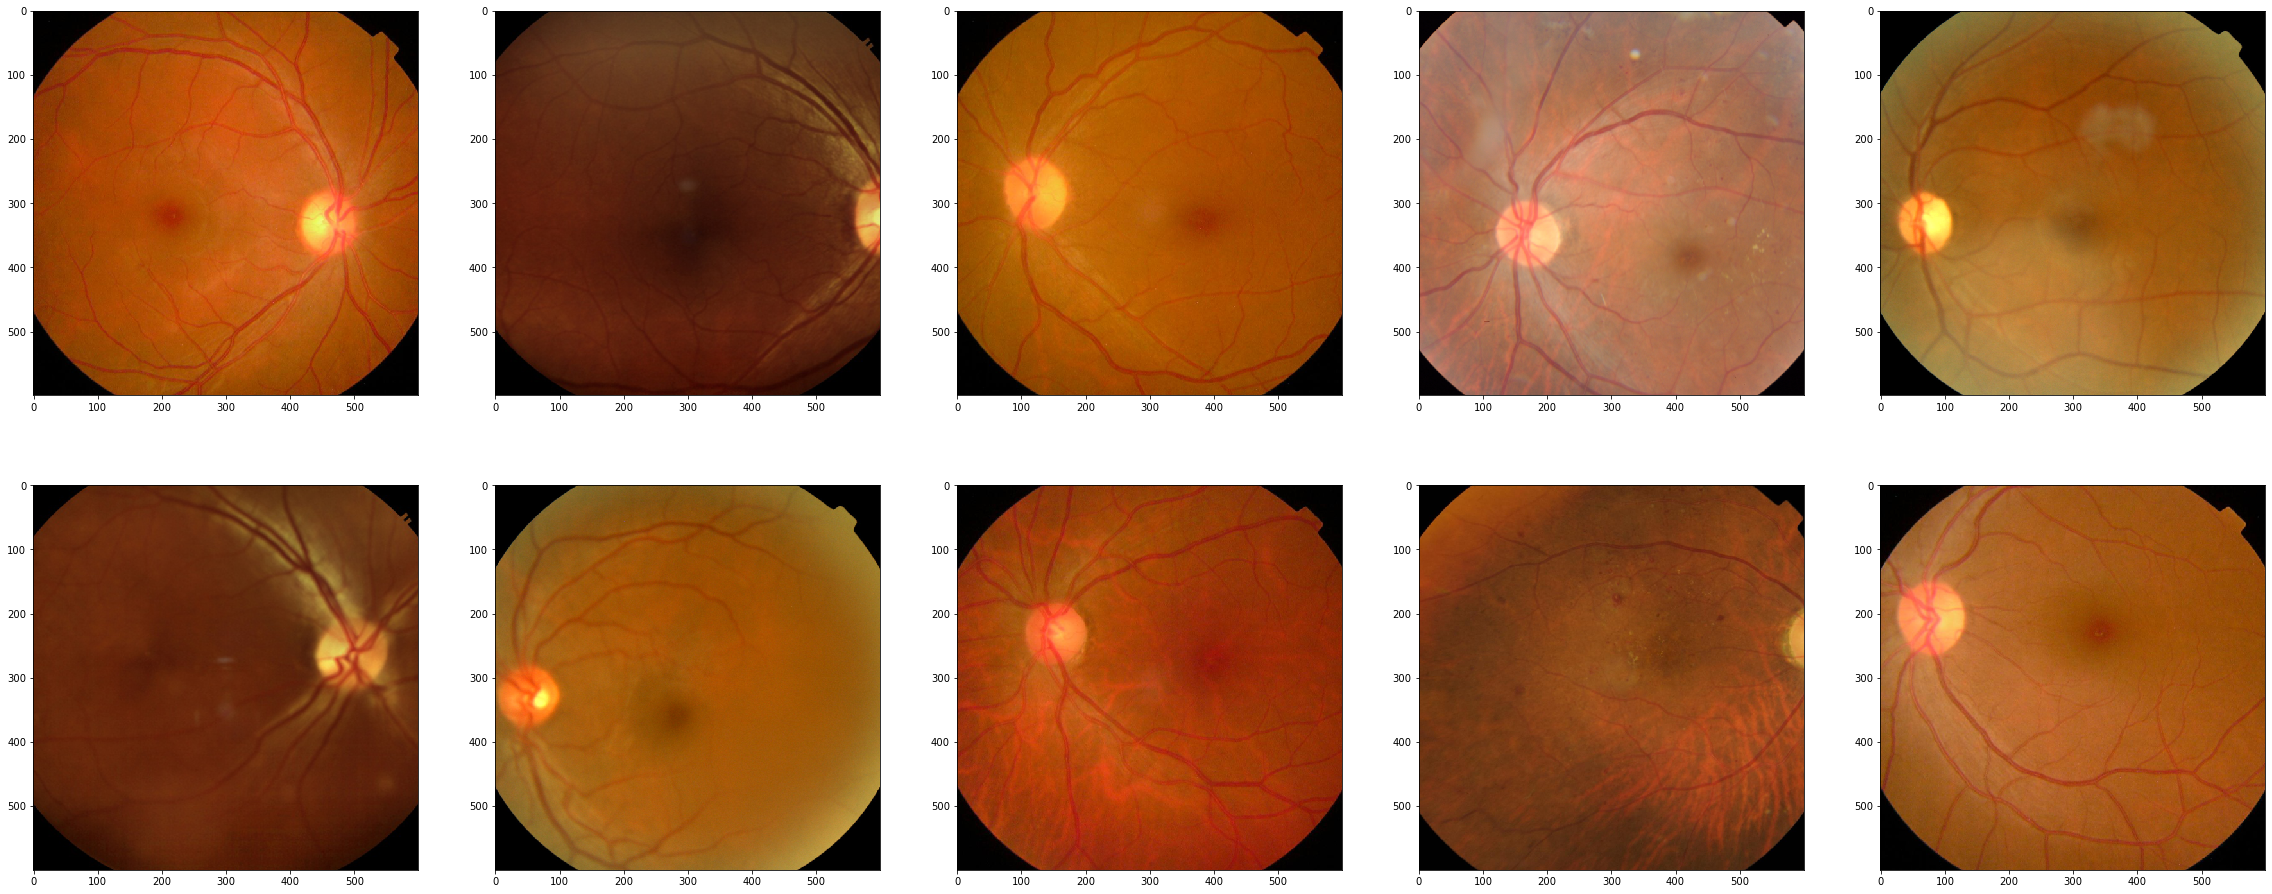

In [12]:
np.random.shuffle(pro_train_imgs)
fig, axs = plt.subplots(2, n_samples // 2, figsize=(40, 16))
for i in range(n_samples // 2):
    train_img = np.load(str(pro_train_imgs[i]))
    axs[0, i].imshow(train_img)
    print(train_img.shape)
for i in range(n_samples // 2, n_samples):
    train_img = np.load(str(pro_train_imgs[i]))
    print(train_img.shape)
    axs[1, i - n_samples // 2].imshow(train_img)

## Processed image statistics

In [13]:
means = np.zeros((3, len(pro_train_imgs)))
mean_residuals = np.zeros((3, len(pro_train_imgs)))

def load(filename):
    x = np.load(filename)
    return T.ToTensor()(x)

with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(load, str(f)): f for f in pro_train_imgs}
    for future in tqdm(as_completed(results), total=len(pro_train_imgs)):
        img = future.result()
        f = results[future]
        idx = pro_train_imgs.index(f)
        
        # extract mean and variance for nonzero parts of image
        nonzero = (img > 0)
        for c in range(3):
            values = img[c, :, :].view(-1)[nonzero[c, :, :].view(-1)]
            means[c, idx] = values.mean()
            
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(load, str(f)): f for f in pro_train_imgs}
    for future in tqdm(as_completed(results), total=len(pro_train_imgs)):
        img = future.result()
        f = results[future]
        idx = pro_train_imgs.index(f)
        
        # extract mean and variance for nonzero parts of image
        nonzero = (img > 0)
        for c in range(3):
            values = img[c, :, :].view(-1)[nonzero[c, :, :].view(-1)]
            mean_residuals[c, idx] = ((values - means[c, :].mean()) ** 2).mean()

100%|██████████| 3662/3662 [00:47<00:00, 76.96it/s] 


In [14]:
print(means[0, :].mean())
print(means[1, :].mean())
print(means[2, :].mean())

0.538958229124546
0.2874618285584326
0.09268383433379065


In [15]:
print(np.sqrt(mean_residuals[0, :].mean()))
print(np.sqrt(mean_residuals[1, :].mean()))
print(np.sqrt(mean_residuals[2, :].mean()))

0.18737475533161674
0.10759164571418119
0.0794110442783131


In [16]:
0.46074811100811774
0.24670958731736836
0.08010832900893707

0.22168294383428308
0.12445088688150698
0.05504030630811819

0.05504030630811819